# Using The Super Resolution Convolutional Neural Network for Image Restoration

The goal of super-resolution (SR) is to recover a high resolution image from a low resolution input, or as they might say on any modern crime show, enhance!

To accomplish this goal, we will be deploying the super-resolution convolution neural network (SRCNN) using Keras. This network was published in the paper, "Image Super-Resolution Using Deep Convolutional Networks" by Chao Dong, et al. in 2014. You can read the full paper at https://arxiv.org/abs/1501.00092.

As the title suggests, the SRCNN is a deep convolutional neural network that learns end-to-end mapping of low resolution to high resolution images. As a result, we can use it to improve the image quality of low resolution images. To evaluate the performance of this network, we will be using three image quality metrics: peak signal to noise ratio (PSNR), mean squared error (MSE), and the structural similarity (SSIM) index.

In this particular project, we will be using OpenCV to pre and post process our images.We will frequently be converting our images back and forth between the RGB, BGR, and YCrCb color spaces. This is necessary because the SRCNN network was trained on the luminance (Y) channel in the YCrCb color space.

In [55]:
import keras
import numpy
import matplotlib.pyplot as plt
import cv2
import skimage
from skimage.measure import compare_ssim as ssim
import numpy as np
from keras.models import Sequential
from keras.layers import Conv2D,Dense,MaxPooling2D
from keras.optimizers import Adam,SGD
import math
import os
%matplotlib inline

In [56]:
# define a function for peak signal-to-noise ratio (PSNR)
def psnr(target, ref):
         
    # assume RGB image
    target_data = target.astype(float)
    ref_data = ref.astype(float)

    diff = ref_data - target_data
    diff = diff.flatten('C')

    rmse = math.sqrt(np.mean(diff ** 2.))

    return 20 * math.log10(255. / rmse)

# define function for mean squared error (MSE)
def mse(target, ref):
    # the MSE between the two images is the sum of the squared difference between the two images
    err = np.sum((target.astype('float') - ref.astype('float')) ** 2)
    err /= float(target.shape[0] * target.shape[1])
    
    return err

# define function that combines all three image quality metrics
def compare_images(target, ref):
    scores = []
    scores.append(psnr(target, ref))
    scores.append(mse(target, ref))
    scores.append(ssim(target, ref, multichannel =True))
    
    return scores

In [57]:
def prepare_images(path, factor):
    
    # loop through the files in the directory
    for file in os.listdir(path):
        
        # open the file
        img = cv2.imread(path + '/' + file)
        
        # find old and new image dimensions
        h, w, _ = img.shape
        new_height = h // factor
        new_width = w // factor
        
        # resize the image - down
        img = cv2.resize(img, (new_width, new_height), interpolation = cv2.INTER_LINEAR)
        
        # resize the image - up
        img = cv2.resize(img, (w, h), interpolation = cv2.INTER_LINEAR)
        
        # save the image
        print('Saving {}'.format(file))
        cv2.imwrite('images/{}'.format(file), img)

In [58]:
prepare_images('source images/', 2)

Saving baboon.bmp
Saving baby_GT.bmp
Saving barbara.bmp
Saving bird_GT.bmp
Saving butterfly_GT.bmp
Saving comic.bmp
Saving face.bmp
Saving flowers.bmp
Saving foreman.bmp
Saving head_GT.bmp
Saving lenna.bmp
Saving monarch.bmp
Saving pepper.bmp
Saving ppt3.bmp
Saving woman_GT.bmp
Saving zebra.bmp


In [59]:
for file in os.listdir('images/'):
    
    # open target and reference images
    target = cv2.imread('images/{}'.format(file))
    ref = cv2.imread('source images/{}'.format(file))
    
    # calculate score
    scores = compare_images(target, ref)

    # print all three scores with new line characters (\n) 
    print('{}\nPSNR: {}\nMSE: {}\nSSIM: {}\n'.format(file, scores[0], scores[1], scores[2]))

C:\Python36\lib\site-packages\ipykernel_launcher.py:28: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.


baboon.bmp
PSNR: 22.157084083442548
MSE: 1187.1161333333334
SSIM: 0.629277587900277

baby_GT.bmp
PSNR: 34.37180640966199
MSE: 71.28874588012695
SSIM: 0.9356987872724932

barbara.bmp
PSNR: 25.906629837568126
MSE: 500.65508535879627
SSIM: 0.8098632646406401

bird_GT.bmp
PSNR: 32.896644728720005
MSE: 100.12375819830247
SSIM: 0.9533644866026473

butterfly_GT.bmp
PSNR: 24.782076560337416
MSE: 648.6254119873047
SSIM: 0.8791344763843051

comic.bmp
PSNR: 23.799861502225532
MSE: 813.2338836565096
SSIM: 0.8347335416398209

face.bmp
PSNR: 30.99220650287191
MSE: 155.23189718546524
SSIM: 0.8008439492289884

flowers.bmp
PSNR: 27.454504805386147
MSE: 350.55093922651935
SSIM: 0.8697286286974628

foreman.bmp
PSNR: 30.14456532664372
MSE: 188.6883483270202
SSIM: 0.933268417388899

head_GT.bmp
PSNR: 31.020502848237534
MSE: 154.2237755102041
SSIM: 0.8011121330733371

lenna.bmp
PSNR: 31.47349297867539
MSE: 138.94800567626953
SSIM: 0.8460989200521499

monarch.bmp
PSNR: 30.196242365288896
MSE: 186.45643615722

In [60]:
# define the SRCNN model
def SRCNN():
    model = Sequential()
    model.add(Conv2D(filters=128,kernel_size=(9,9),kernel_initializer='glorot_uniform',activation='relu',
                     padding='valid',use_bias=True,input_shape=(None,None,1)))
    
    model.add(Conv2D(filters=64,kernel_size=(3,3),kernel_initializer='glorot_uniform',activation='relu',
                     padding='same',use_bias=True))
    
    model.add(Conv2D(filters=1,kernel_size=(5,5),kernel_initializer='glorot_uniform',activation='linear',
                     padding='valid',use_bias=True))
    adam = Adam(lr=0.0003)
    
    model.compile(optimizer=adam,loss='mean_squared_error',metrics=['mean_squared_error'])
    
    return model   

In [61]:
srcnn = SRCNN()
srcnn.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_16 (Conv2D)           (None, None, None, 128)   10496     
_________________________________________________________________
conv2d_17 (Conv2D)           (None, None, None, 64)    73792     
_________________________________________________________________
conv2d_18 (Conv2D)           (None, None, None, 1)     1601      
Total params: 85,889
Trainable params: 85,889
Non-trainable params: 0
_________________________________________________________________


In [62]:
# define necessary image processing functions

def modcrop(img, scale):
    tmpsz = img.shape
    sz = tmpsz[0:2]
    sz = sz - np.mod(sz, scale)
    img = img[0:sz[0], 1:sz[1]]
    return img


def shave(image, border):
    img = image[border: -border, border: -border]
    return img


In [63]:
def predict(image_path):
    
    # load the srcnn model with weights
    srcnn = SRCNN()
    srcnn.load_weights('weights.h5')
    
    # load the degraded and reference images
    path, file = os.path.split(image_path)
    degraded = cv2.imread(image_path)
    ref = cv2.imread('source images/{}'.format(file))
    
    # preprocess the image with modcrop
    ref = modcrop(ref, 3)
    degraded = modcrop(degraded, 3)
    
    # convert the image to YCrCb - (srcnn trained on Y channel)
    temp = cv2.cvtColor(degraded, cv2.COLOR_BGR2YCrCb)
    
    # create image slice and normalize  
    Y = numpy.zeros((1, temp.shape[0], temp.shape[1], 1), dtype=float)
    Y[0, :, :, 0] = temp[:, :, 0].astype(float) / 255
    
    # perform super-resolution with srcnn
    pre = srcnn.predict(Y, batch_size=1)
    
    # post-process output
    pre *= 255
    pre[pre[:] > 255] = 255
    pre[pre[:] < 0] = 0
    pre = pre.astype(np.uint8)
    
    # copy Y channel back to image and convert to BGR
    temp = shave(temp, 6)
    temp[:, :, 0] = pre[0, :, :, 0]
    output = cv2.cvtColor(temp, cv2.COLOR_YCrCb2BGR)
    
    # remove border from reference and degraged image
    ref = shave(ref.astype(np.uint8), 6)
    degraded = shave(degraded.astype(np.uint8), 6)
    
    # image quality calculations
    scores = []
    scores.append(compare_images(degraded, ref))
    scores.append(compare_images(output, ref))
    
    # return images and scores
    return ref, degraded, output, scores

C:\Python36\lib\site-packages\ipykernel_launcher.py:28: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.


Degraded Image: 
PSNR: 24.752462626436284
MSE: 653.0634118967453
SSIM: 0.8788410517538944

Reconstructed Image: 
PSNR: 30.38213886603309
MSE: 178.64370982552802
SSIM: 0.9519721343623928



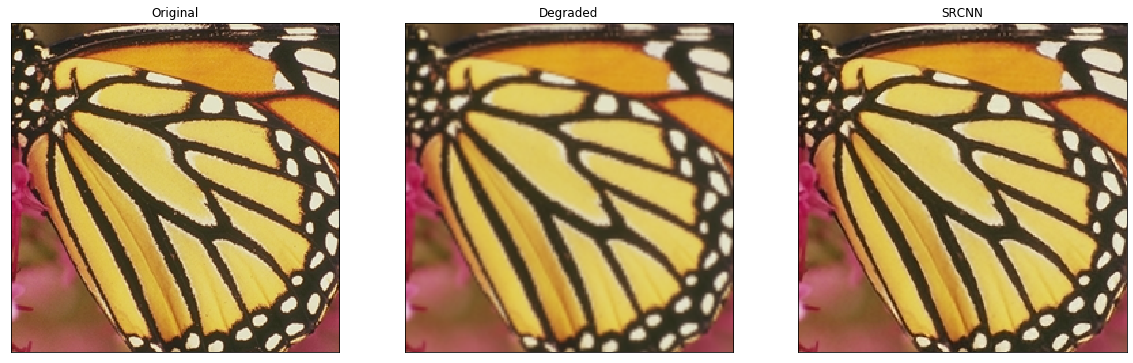

In [64]:
ref, degraded, output, scores = predict('images/butterfly_GT.bmp')

# print all scores for all images
print('Degraded Image: \nPSNR: {}\nMSE: {}\nSSIM: {}\n'.format(scores[0][0], scores[0][1], scores[0][2]))
print('Reconstructed Image: \nPSNR: {}\nMSE: {}\nSSIM: {}\n'.format(scores[1][0], scores[1][1], scores[1][2]))


# display images as subplots
fig, axs = plt.subplots(1, 3, figsize=(20, 8))
axs[0].imshow(cv2.cvtColor(ref, cv2.COLOR_BGR2RGB))
axs[0].set_title('Original')
axs[1].imshow(cv2.cvtColor(degraded, cv2.COLOR_BGR2RGB))
axs[1].set_title('Degraded')
axs[2].imshow(cv2.cvtColor(output, cv2.COLOR_BGR2RGB))
axs[2].set_title('SRCNN')

# remove the x and y ticks
for ax in axs:
    ax.set_xticks([])
    ax.set_yticks([])

In [65]:
for file in os.listdir('images'):
    
    # perform super-resolution
    ref, degraded, output, scores = predict('images/{}'.format(file))
    
    # display images as subplots
    fig, axs = plt.subplots(1, 3, figsize=(20, 8))
    axs[0].imshow(cv2.cvtColor(ref, cv2.COLOR_BGR2RGB))
    axs[0].set_title('Original')
    axs[1].imshow(cv2.cvtColor(degraded, cv2.COLOR_BGR2RGB))
    axs[1].set_title('Degraded')
    axs[1].set(xlabel = 'PSNR: {}\nMSE: {} \nSSIM: {}'.format(scores[0][0], scores[0][1], scores[0][2]))
    axs[2].imshow(cv2.cvtColor(output, cv2.COLOR_BGR2RGB))
    axs[2].set_title('SRCNN')
    axs[2].set(xlabel = 'PSNR: {} \nMSE: {} \nSSIM: {}'.format(scores[1][0], scores[1][1], scores[1][2]))

    # remove the x and y ticks
    for ax in axs:
        ax.set_xticks([])
        ax.set_yticks([])
      
    print('Saving {}'.format(file))
    fig.savefig('Outputs/{}.png'.format(os.path.splitext(file)[0])) 
    plt.close()

C:\Python36\lib\site-packages\ipykernel_launcher.py:28: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.


Saving baboon.bmp
Saving baby_GT.bmp
Saving barbara.bmp
Saving bird_GT.bmp
Saving butterfly_GT.bmp
Saving comic.bmp
Saving face.bmp
Saving flowers.bmp
Saving foreman.bmp
Saving head_GT.bmp
Saving lenna.bmp
Saving monarch.bmp
Saving pepper.bmp
Saving ppt3.bmp
Saving woman_GT.bmp
Saving zebra.bmp
